In [33]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.cross_validation import *
from scipy import stats

#New Small DF

In [34]:
matchup_df = pd.read_csv("temp_matchupdf.csv")

In [35]:
dftouse=matchup_df.copy()

In [36]:
dftouse.dtypes

AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
bID            object
matchID        object
pID            object
AVG           float64
OBP           float64
ov_AB           int64
ov_H            int64
ov_PA           int64
ov_SAC          int64
ov_SO           int64
ov_TB           int64
ov_W            int64
ov_FACED        int64
ov_AVG        float64
ov_OBP        float64
ov_SO_PCT     float64
ov_W_PCT      float64
ov_H_PCT      float64
ovp_AB          int64
ovp_H           int64
ovp_PA          int64
ovp_SAC         int64
ovp_SO          int64
ovp_TB          int64
ovp_W           int64
ovp_FACED       int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
ovp_AVG       float64
ovp_OBP       float64
dtype: object

In [37]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [38]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [39]:
def make_smaller(df, pacountp, pacountb):
    smallidf1=df[(df.ovp_PA > pacountp) & (df.ov_PA > pacountb)]
    smalldf=recompute_frame(smallidf1)
    return smalldf

In [40]:
def make_smaller_gen(df, col, limit, greater=True):
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

In [93]:
#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller_gen(dftouse, 'PA', 25)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 100, 100)

In [110]:
smalldf.to_csv('small_reduced.csv', index=False)

In [94]:
smalldf.shape

(13179, 39)

In [95]:
smalldf['AVG'] = smalldf['H']/smalldf['AB']
smalldf['OBP'] = (smalldf['H'] + smalldf['W'])/smalldf['PA']

In [96]:
#Copied and pasted over from Baseline model

trainlist=[]
testlist=[]
validatelist=[]
take=21 #21 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 100 pitchers
        train_rows, test_valid_rows = train_test_split(v, test_size=take)
        trainlist.append(train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist.append(valid_rows) 
        testlist.append(test_rows) 
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(13095, 39) (48, 39) (36, 39)


#Make the uuids and uiids from the traindf for each batter and pitcher

In [97]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids

In [98]:
from sklearn.linear_model import Ridge
features=np.concatenate([ubids,upids])
features.shape

(961L,)

In [99]:
traindf.head(10)

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_FACED,ov_AVG,ov_OBP,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP
819,abreb001,armat002,31,10,38,R,0,9,26,7,abreb001_armat002,0.322581,0.447368,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,480,140,564,6,83,294,84,15,0.147163,0.148936,0.248227,0.291667,0.397163
820,abreb001,astap001,31,10,41,R,0,6,23,10,abreb001_astap001,0.322581,0.487805,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2304,699,2595,27,400,1427,291,62,0.154143,0.112139,0.269364,0.303385,0.381503
821,abreb001,batim001,33,12,38,R,1,2,23,5,abreb001_batim001,0.363636,0.447368,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1684,497,1930,33,184,944,246,58,0.095337,0.127461,0.257513,0.295131,0.384974
822,abreb001,beckj002,79,14,100,R,0,25,28,21,abreb001_beckj002,0.177215,0.350000,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2502,637,2769,27,606,1259,267,67,0.218852,0.096425,0.230047,0.254596,0.326472
823,abreb001,bedae001,29,5,33,L,1,7,5,4,abreb001_bedae001,0.172414,0.272727,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1067,283,1181,8,249,505,114,36,0.210838,0.096528,0.239627,0.265230,0.336156
824,abreb001,benea001,23,8,27,R,1,2,18,4,abreb001_benea001,0.347826,0.444444,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1892,525,2118,25,374,1107,226,48,0.176582,0.106704,0.247875,0.277484,0.354580
825,abreb001,bensk001,28,6,31,R,0,4,12,3,abreb001_bensk001,0.214286,0.290323,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,747,216,857,11,109,437,110,27,0.127188,0.128355,0.252042,0.289157,0.380397
826,abreb001,bondj001,22,10,28,R,0,4,20,6,abreb001_bondj001,0.454545,0.571429,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,1353,393,1510,16,262,799,157,42,0.173510,0.103974,0.260265,0.290466,0.364238
827,abreb001,browk001,36,11,39,R,0,5,19,3,abreb001_browk001,0.305556,0.358974,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,2555,665,2805,23,461,1129,250,71,0.164349,0.089127,0.237077,0.260274,0.326203
828,abreb001,buehm001,22,10,26,L,1,5,18,4,abreb001_buehm001,0.454545,0.538462,2439,669,2845,23,502,1338,406,69,0.274293,0.377856,0.17645,0.142707,0.235149,5728,1669,6147,70,763,3102,419,142,0.124126,0.068163,0.271515,0.291376,0.339678


In [100]:
#function to produce the design matrix
def getmats(indf):
    
    results_avg = indf['AVG']
    results_obp = indf['OBP']
    
    n_cols = len(features)
    n_rows = len(indf)
    
    #fill matrix with zeros
    mats = np.zeros((n_rows, n_cols))

    #for each element in features, check for match in every row, whether business or user, and switch to one
    for i in range(0, len(ubids)):
        for j in range(0, n_rows):
            if features[i] == indf['bID'].values[j]:
                mats[j, i] = 1
    for i in range(len(ubids), n_cols):
        for j in range(0, n_rows):
            if features[i] == indf['pID'].values[j]:
                mats[j, i] = 1
    return mats, results_avg, results_obp

In [101]:
%%time
designm, avg, obp = getmats(traindf)
validatedm, validate_avg, validate_obp = getmats(validatedf)

Wall time: 1min 1s


In [102]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [103]:
%%time

#regressing averages
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 10, 100, 1000]
vdict={}
rdict={}
for a in alphas:
    #perform regression for each alpha and store in rdict, keyed by the alpha
    ridge_reg = Ridge(alpha=a)
    
    #we'll do the average for now
    ridge_reg = ridge_reg.fit(designm, avg)
    rdict[a]=ridge_reg
    
    #calculate the RMSE for each alpha, store in vdict
    pred = ridge_reg.predict(validatedm)
    rmse = get_rmse(pred, validate_avg)
    vdict[a]=rmse

Wall time: 3.96 s


In [104]:
vdict

{0.01: 0.089990892259923988,
 0.1: 0.089941138332694334,
 10: 0.089342172492914318,
 100: 0.090642472804778509,
 1000: 0.092723990671586654}

In [105]:
minerroralpha=min(vdict, key=vdict.get)
print minerroralpha
regr=rdict[minerroralpha] 

10


In [106]:
regr.intercept_

0.28034180680573334

The RMSE is a lot smaller here than before. 

#Prediction

In [107]:
testdm, test_avg, test_obp = getmats(testdf)

In [108]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline_r 0.0824765971834


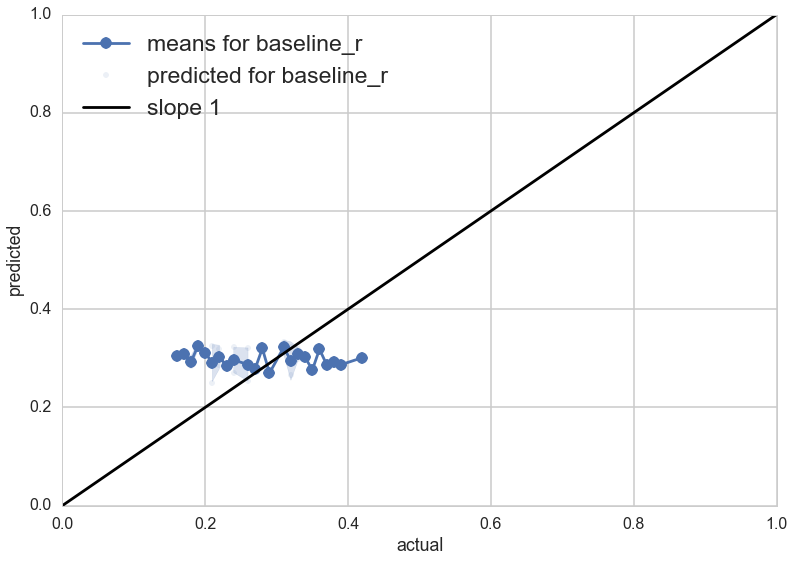

In [109]:
#Comment these out obviously
predictions={}
predictions_valid={}

from sklearn.linear_model import Ridge

pred_test = regr.predict(testdm)
predictions['baseline_r'] = pred_test

pred_valid = regr.predict(validatedm)
predictions_valid['baseline_r'] = pred_valid

compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True);

In [ ]:
#ax=plt.gca()
#compare_results(test_avg,predictions['baseline_r'], model="baseline_r", predicteds=True, axis=ax);
#compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True, onsame=ax);